## Functions

In [1]:
import scipy
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.metrics import mean_squared_error

In [10]:
def plot_time_comparison(seegprep_signal, fieldtrip_signal, srate, seconds=60):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

    time = np.arange(0,len(seegprep_signal))/srate

    axs[0].plot(time[0:srate*seconds], seegprep_signal[0:srate*seconds], 'b', linewidth=0.1)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude ($\mu$V)')
    axs[0].set_title('sEEGPrep Output')

    axs[1].plot(time[0:srate*seconds], fieldtrip_signal[0:srate*seconds], 'b', linewidth=0.1)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Amplitude ($\mu$V)')
    axs[1].set_title('Fieldtrip Output')

    plt.tight_layout()

In [2]:
def plot_freq_comp(seegprep_signal, fieldtrip_signal, srate, titles=['sEEGPrep Output', 'Fieldtrip Output']):
    # Freq domain response
    length_segment = 3.0
    f_seegpre, welchpow_seegprep = welch(seegprep_signal, fs=srate, nperseg=int(length_segment*srate))
    f_ft, welchpow_ft = welch(fieldtrip_signal, fs=srate, nperseg=int(length_segment*srate))

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

    # Plot until 200 hz
    if srate > 200:
        f_max = f_ft.tolist().index(100)
    else:
        f_max = len(f_ft)
        
    axs[0].plot(f_seegpre[0:f_max], welchpow_seegprep[0:f_max], 'b', linewidth=0.8)
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
    axs[0].set_title(titles[0])

    axs[1].plot(f_ft[0:f_max], welchpow_ft[0:f_max], 'b', linewidth=0.8)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('Amplitude ($\mu$V$^2$/Hz)')
    axs[1].set_title(titles[1])

    plt.tight_layout()


In [4]:
def plot_stft_comp(seegprep_signal, fieldtrip_signal, srate, nperseg, seconds=60, freq_range = [0,20]):
    # Freq domain response
    length_segment = 3.0
    f_s, t_s, Zxx_seegprep = scipy.signal.stft(seegprep_signal[0:seconds*srate], fs=srate, nperseg=nperseg)
    f_ft, t_ft, Zxx_ft = scipy.signal.stft(fieldtrip_signal[0:seconds*srate], fs=srate, nperseg=nperseg)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))

    # Plot until 100 hz
    f_max = np.argmin(np.abs(f_ft-freq_range[-1]))
    f_min = np.argmin(np.abs(f_ft-freq_range[0]))
    
    vmin=min(np.min(np.abs(Zxx_seegprep[f_min:f_max,:])), np.min(np.abs(Zxx_ft[f_min:f_max,:])))
    vmax=min(np.max(np.abs(Zxx_seegprep[f_min:f_max,:])), np.max(np.abs(Zxx_ft[f_min:f_max,:])))
        
    c = axs[0].pcolormesh(t_s, f_s[f_min:f_max], np.abs(Zxx_seegprep)[f_min:f_max,:], vmin=vmin, vmax=vmax)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Frequency (Hz)')
    axs[0].set_title('sEEGPrep Output - STFT Magnitude')
    plt.colorbar(c, ax=axs[0], label='Amplitude ($\mu$V)')

    axs[1].pcolormesh(t_ft, f_ft[f_min:f_max], np.abs(Zxx_ft)[f_min:f_max,:], vmin=vmin, vmax=vmax)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Frequency (Hz)')
    axs[1].set_title('Fieldtrip Output - STFT Magnitude')
    plt.colorbar(c, ax=axs[1], label='Amplitude ($\mu$V)') 
    # plt.colorbar(z1_plot,cax=axs[1])

    plt.tight_layout()


In [5]:
def get_RMSE(seegprep_signal, fieldtrip_signal, srate):
    time_rmse = np.sqrt(mean_squared_error(seegprep_signal, fieldtrip_signal))
    
    # Freq
    length_segment = 3.0
    f_seegpre, welchpow_seegprep = welch(seegprep_signal, fs=srate, nperseg=int(length_segment*srate))
    f_ft, welchpow_ft = welch(fieldtrip_signal, fs=srate, nperseg=int(length_segment*srate))
    
    freq_rmse = np.sqrt(mean_squared_error(welchpow_seegprep, welchpow_ft))
    
    return {
        'RMSE - Time Domain ($\mu$V)': time_rmse,
        'Spectral error ($\mu$V$^2$/Hz)': freq_rmse
    }

def get_corr(seegprep_signal, fieldtrip_signal, srate):
    # Compute the Pearson correlation coefficient
    time_corr = np.corrcoef(seegprep_signal, fieldtrip_signal)[0, 1]
    
    # Freq
    length_segment = 3.0
    f_seegpre, welchpow_seegprep = welch(seegprep_signal, fs=srate, nperseg=int(length_segment*srate))
    f_ft, welchpow_ft = welch(fieldtrip_signal, fs=srate, nperseg=int(length_segment*srate))
    
    freq_corr = np.corrcoef(welchpow_seegprep, welchpow_ft)[0, 1]
    
    return {
        'Time domain correlation': time_corr,
        'Spectral correlation': freq_corr
    }

In [6]:
# Run permutation with median
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

In [7]:
def map_indices_from_list1_to_list2(small_list, large_list):
    # Dictionary to hold the mapping of elements to their indices
    index_map = {}
    
    # Loop through the large_list and map indices
    for index, item in enumerate(large_list):
        # If the item is in the small_list, append the index to the list in the dictionary
        if item in small_list:
            index_map[small_list.index(item)] = index
    
    return index_map

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import combinations

def language_comparison(labels_python, labels_matlab, signals_python, signals_matlab, srate, map_signals = True):
    # Find mapping between labels
    if map_signals:
        map_idx = map_indices_from_list1_to_list2(labels_python, labels_matlab)
    else:
        map_idx = dict(zip(range(signals_python.shape[0]),range(signals_matlab.shape[0])))
    
    # Create dict
    total_dict = {
        'Metric': [],
        'Value': [],
        'chn': []
    }
    for idx in range(len(signals_python)):

        total_dict['chn'] += [idx for i in range(2)]
        # Get metrics
        metrics = get_corr(signals_python[idx,:].squeeze(), signals_matlab[map_idx[idx],:].squeeze(), srate=srate)
        total_dict['Metric'] += list(metrics.keys())
        total_dict['Value'] += list(metrics.values())

    df = pd.DataFrame(total_dict)
    df = df.dropna(how='any')
    
    # Plotting
    # Create new plot
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,5))
    for i, metric in enumerate(df.Metric.unique()):
        df_tmp = df.loc[df.Metric==metric]
        # print(df_tmp)
        # Plot params
        plotting_parameters = {
            'data': df_tmp,
            'y': "Value",
            'x': "Metric",
            'showfliers': False,
            'ax': ax[i]
        }
        # sns.boxplot(data=df_tmp, x="Value", y="Metric", hue='Name_Net')
        with sns.plotting_context('notebook', font_scale = 1):
            
            # Plot with seaborn
            sns.boxplot(**plotting_parameters, showmeans=False,
                    meanprops={'marker':'o',
                               'markerfacecolor':'white', 
                               'markeredgecolor':'black',
                               'markersize':'8'})
            # ax[i].set_ylim(0.99*1*10**6, max(df_tmp.Value.values))
    # Label and show
    plt.tight_layout()
    plt.show()

In [9]:
import matplotlib
font = {'size'   : 12}
matplotlib.rc('font', **font)

## Epoching

In [10]:
import pyedflib
import numpy as np

In [11]:
# sEEGPrep file
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-clip_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx_python = edf_epoch.getSignalLabels().index('LPIn2')
    labels_python = edf_epoch.getSignalLabels()
    signals_python = []
    for sig in range(len(edf_epoch.getSignalLabels())):
        signals_python.append(edf_epoch.readSignal(sig))
    signals_python = np.vstack(signals_python)

In [12]:
# Fieldtrip file
signals_matlab = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/epoching.mat')['signals']
labels_matlab = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/unipolar_labels_matlab.mat')['labels']

In [13]:
labels = []
for label in labels_matlab:
    labels.append(label[0][0])
labels_matlab = labels

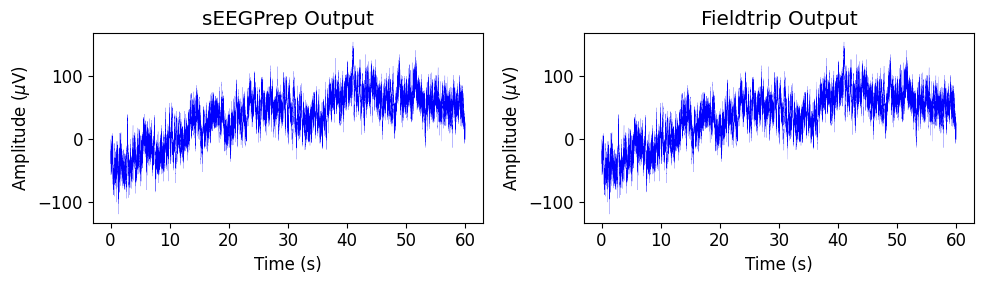

In [34]:
idx_matlab = 72
plot_time_comparison(signals_python[idx_matlab,:], signals_matlab[idx_matlab,:], srate=2048)

In [26]:
np.corrcoef(signals_python[idx_python,:], signals_matlab[idx_matlab,:])[0, 1]

0.9999995857357181

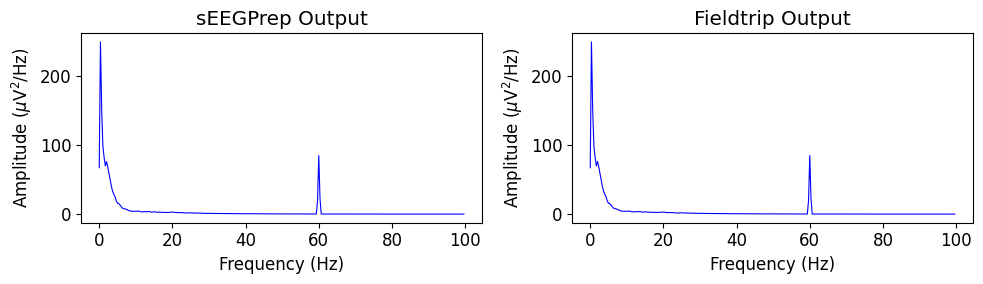

In [15]:
plot_freq_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=2048)

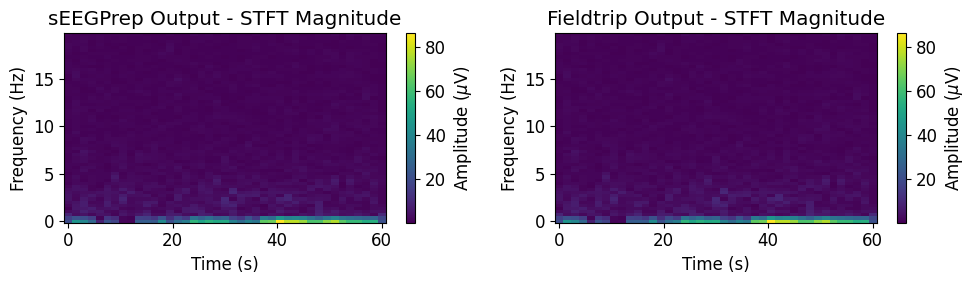

In [16]:
plot_stft_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=2048, nperseg=3*2048)

/local/mcesped.21388032.0/tmp/kslurm-venv-lihc9vmb/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


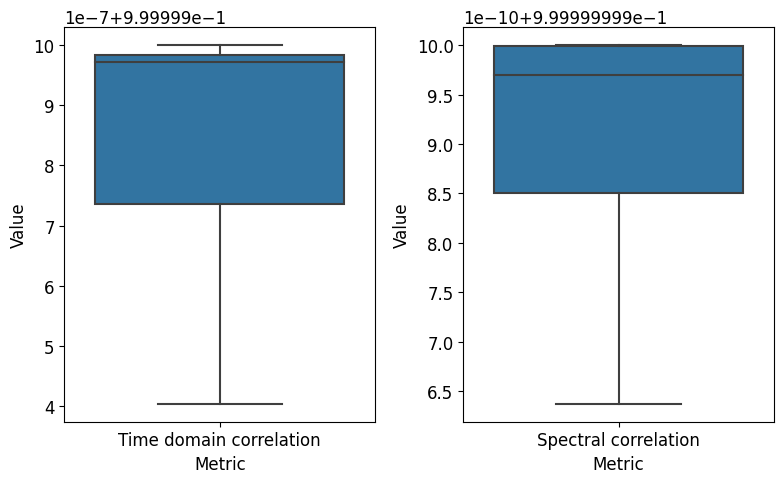

In [64]:
language_comparison(labels_python, labels_matlab, signals_python, signals_matlab, srate=2048)

## Downsampling

In [65]:
# sEEGPrep file
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-dn_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx_python = edf_epoch.getSignalLabels().index('LPIn2')
    labels_python = edf_epoch.getSignalLabels()
    signals_python = []
    for sig in range(len(edf_epoch.getSignalLabels())):
        signals_python.append(edf_epoch.readSignal(sig))
    signals_python = np.vstack(signals_python)
# Fieldtrip file
signals_matlab = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/Downsampling.mat')['signals']
labels_matlab = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/unipolar_labels_matlab.mat')['labels']
labels = []
for label in labels_matlab:
    labels.append(label[0][0])
labels_matlab = labels

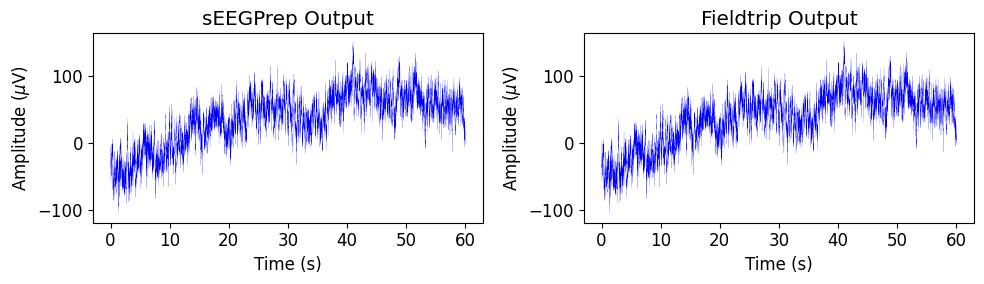

In [66]:
idx_matlab = 72
plot_time_comparison(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200)

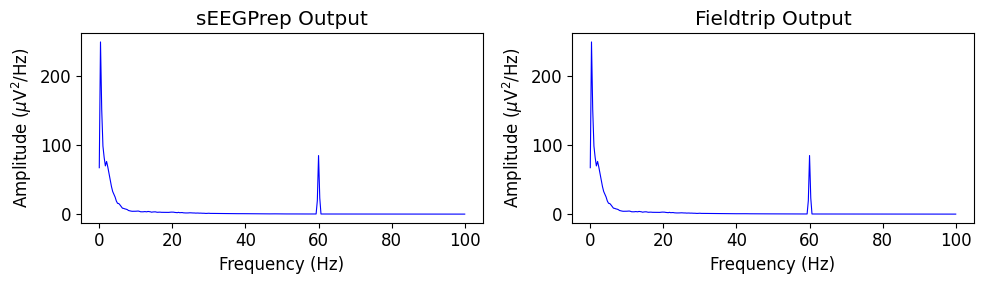

In [67]:
plot_freq_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200)

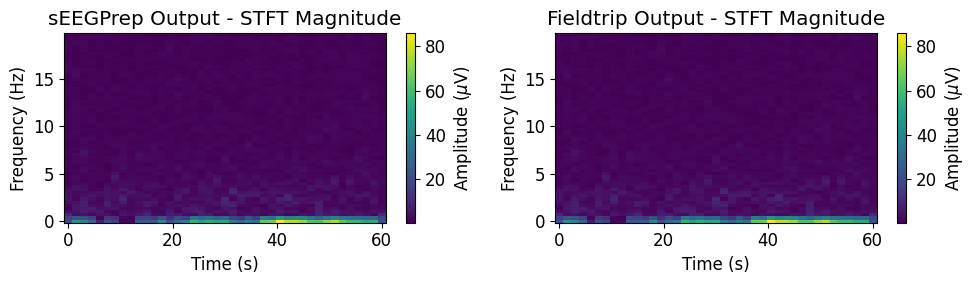

In [68]:
plot_stft_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200, nperseg=3*200)

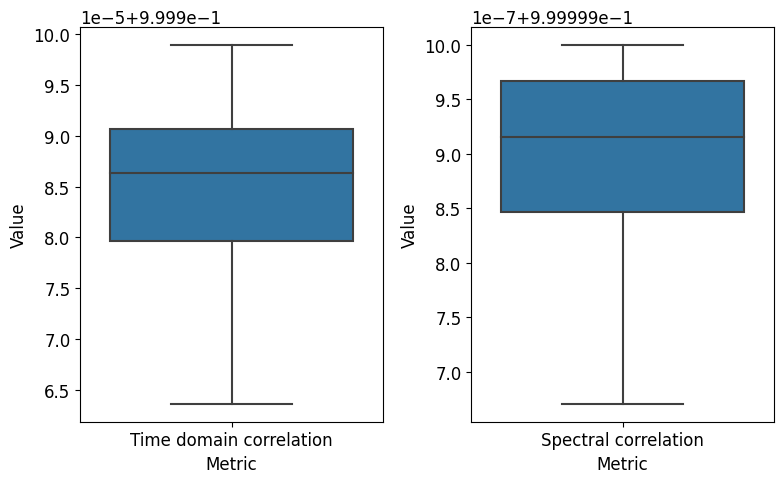

In [69]:
language_comparison(labels_python, labels_matlab, signals_python, signals_matlab, srate=200)

## Highpass filtering

In [70]:
orig_y = signals_python

In [71]:
# sEEGPrep file
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-filt_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx_python = edf_epoch.getSignalLabels().index('LPIn2')
    labels_python = edf_epoch.getSignalLabels()
    signals_python = []
    for sig in range(len(edf_epoch.getSignalLabels())):
        signals_python.append(edf_epoch.readSignal(sig))
    signals_python = np.vstack(signals_python)
# Fieldtrip file
signals_matlab = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/Highpass.mat')['signals']
labels_matlab = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/unipolar_labels_matlab.mat')['labels']
labels = []
for label in labels_matlab:
    labels.append(label[0][0])
labels_matlab = labels

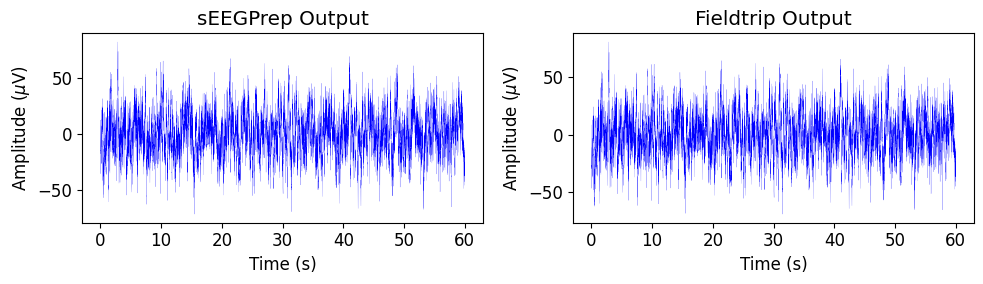

In [72]:
idx_matlab = 72
plot_time_comparison(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200)

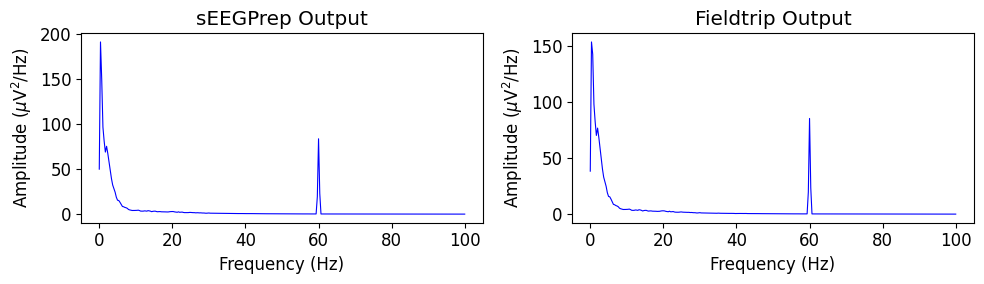

In [73]:
plot_freq_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200)

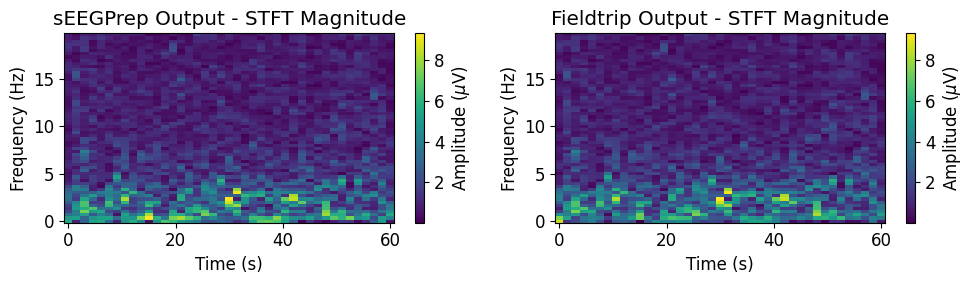

In [74]:
plot_stft_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200, nperseg=3*200)

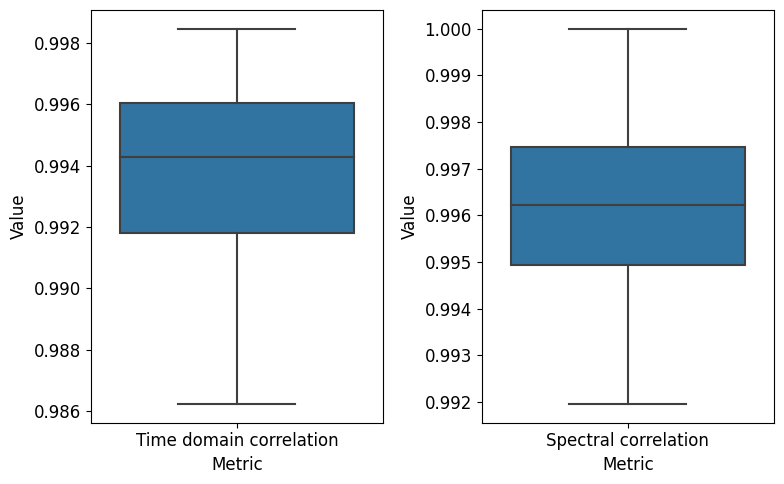

In [75]:
language_comparison(labels_python, labels_matlab, signals_python, signals_matlab, srate=200)

In [58]:
from operator import itemgetter

# Use only those signals used in Python
map_idx = map_indices_from_list1_to_list2(labels_python, labels_matlab)
indices_matlab = itemgetter(*list(range(len(labels_python))))(map_idx)

In [61]:
# Statistical comparison
# Create dict
length_segment = 3.0
fs = 200

total_dict = {
    'Category': [],
    'Frequency component (Hz)': [],
    'Magnitude ($\mu$V$^2$/Hz)': [],
    'chn': []
}
for signals, method in zip((signals_python,signals_matlab[indices_matlab,:]),("Python Filtering", "Matlab Filtering")):
    # Transform to freq domain
    f, w = welch(signals, fs=fs, nperseg=int(length_segment*fs))
    total_dict['Category'] += [method for i in range(4*w.shape[0])]
    for chn in range(w.shape[0]):
        total_dict['chn'] += [chn for i in range(4)]
        total_dict['Frequency component (Hz)'] += np.round(f[0:4],2).tolist()
    total_dict['Magnitude ($\mu$V$^2$/Hz)'] += w[:,0:4].flatten().tolist()

df = pd.DataFrame(total_dict)
df.head()

,Category,Frequency component (Hz),Magnitude ($\mu$V$^2$/Hz),chn
0,Python Filtering,0.00,172.948875,0
1,Python Filtering,0.33,545.080198,0
2,Python Filtering,0.67,406.196079,0
3,Python Filtering,1.00,269.638766,0
4,Python Filtering,0.00,158.693142,1


In [62]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import permutation_test
from itertools import combinations
from statsmodels.stats.multitest import fdrcorrection
from statannotations.Annotator import Annotator

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.33_Python Filtering vs. 0.33_Matlab Filtering: Custom statistical test, P_val:3.243e-01
0.0_Python Filtering vs. 0.0_Matlab Filtering: Custom statistical test, P_val:3.396e-01
0.67_Python Filtering vs. 0.67_Matlab Filtering: Custom statistical test, P_val:4.694e-01
1.0_Python Filtering vs. 1.0_Matlab Filtering: Custom statistical test, P_val:4.842e-01


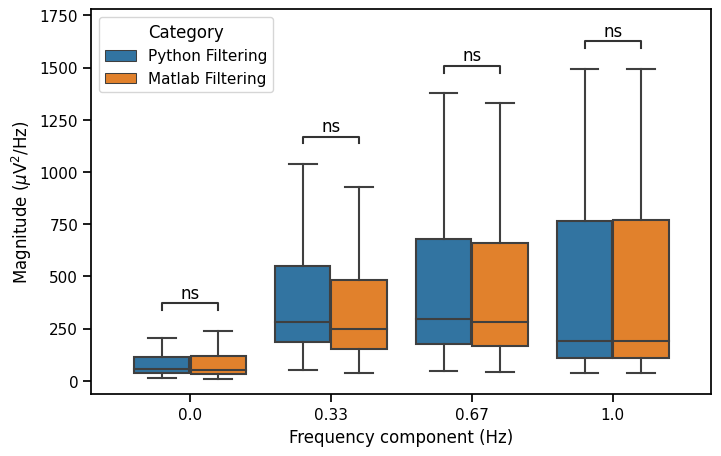

In [63]:
# Generate pairs
elements = df.Category.unique()

# Generate combinations of length 2 without repetition
combinations_without_repetition = list(combinations(elements, 2))

# Run permutation with median
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
    # return np.median(x, axis=axis) - np.median(y, axis=axis)


pairs=[]
p_vals = []
for metric in df['Frequency component (Hz)'].unique():
    p_vals_tmp = []
    for element_1, element_2 in combinations_without_repetition:
        # print(f'\n Comparison between {net_1} and {net_2}\n')
        x = df.loc[(df['Frequency component (Hz)'] == metric).astype(bool) & (df.Category == element_1).astype(bool),'Magnitude ($\mu$V$^2$/Hz)'].values
        y = df.loc[(df['Frequency component (Hz)'] == metric).astype(bool) & (df.Category == element_2).astype(bool),'Magnitude ($\mu$V$^2$/Hz)'].values 
        base = statistic(x, y, 0) # Small network has worst performance
        # Permutation testing
        res = permutation_test((x, y), statistic, vectorized=True,
                           n_resamples=100000, alternative='less' if base<0 else 'greater')
        # print('Real diff',res.statistic)
        # print('p-val: ', res.pvalue)
        p_vals_tmp.append(res.pvalue)
        pairs.append([(metric, element_1), (metric, element_2)])
    # Correct them
    significance, corr_p_vals = fdrcorrection(p_vals_tmp)
    p_vals += corr_p_vals.tolist()

# Plot params
plotting_parameters = {
    'data': df,
    'y': "Magnitude ($\mu$V$^2$/Hz)",
    'x': "Frequency component (Hz)",
    'hue':'Category',
    'showfliers': False,
}
# sns.boxplot(data=df_tmp, x="Value", y="Metric", hue='Name_Net')
with sns.plotting_context('notebook', font_scale = 1):
    # Create new plot
    ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
    # Plot with seaborn
    ax = sns.boxplot(**plotting_parameters, showmeans=False,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
    # Add annotations
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.configure(text_format="star")
    annotator.set_pvalues_and_annotate(p_vals)
    # Label and show
    plt.show()

## Reref

In [76]:
# sEEGPrep file
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-reref_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx_python = edf_epoch.getSignalLabels().index('LPIn2-3')
    labels_python = edf_epoch.getSignalLabels()
    signals_python = []
    for sig in range(len(edf_epoch.getSignalLabels())):
        signals_python.append(edf_epoch.readSignal(sig))
    signals_python = np.vstack(signals_python)
# Fieldtrip file
signals_matlab = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/Reref.mat')['signals']
labels_matlab = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/bipolar_labels_matlab.mat')['labels']
labels = []
for label in labels_matlab:
    labels.append(label[0][0])
labels_matlab = labels

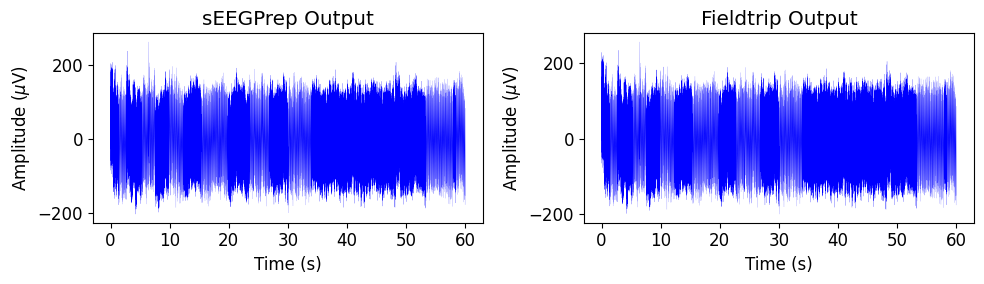

In [77]:
idx_matlab = labels_matlab.index('LPIn2-LPIn3')
plot_time_comparison(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200)

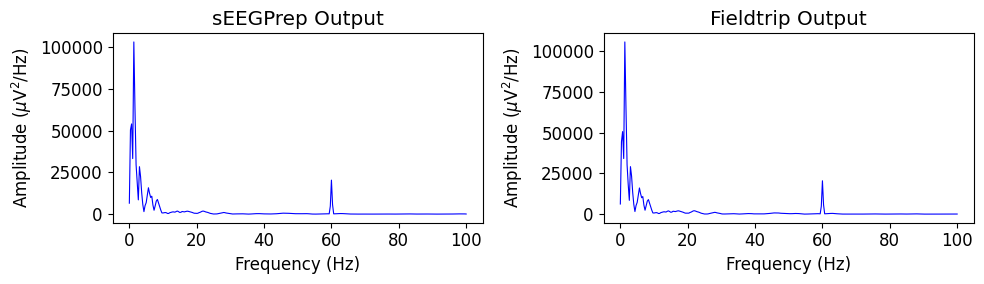

In [78]:
plot_freq_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200)

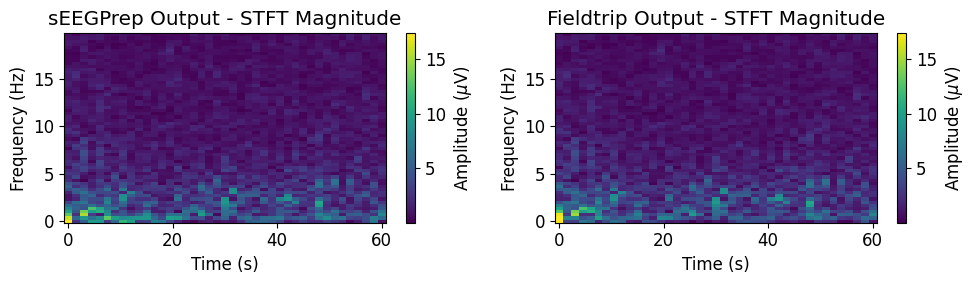

In [79]:
plot_stft_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200, nperseg=3*200)

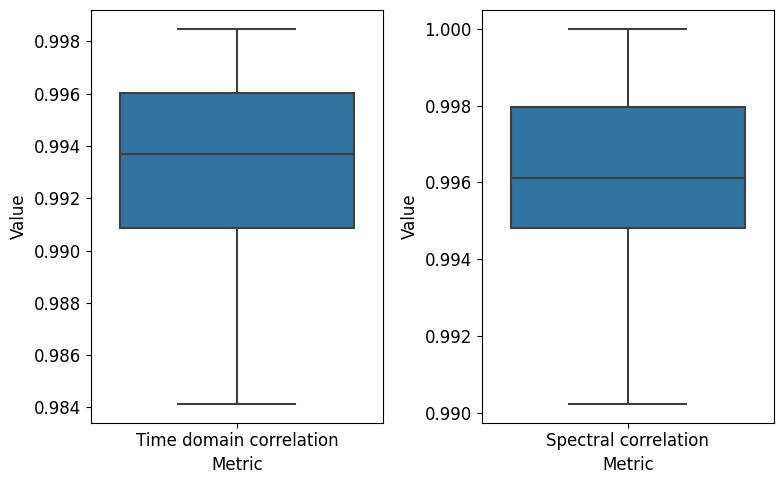

In [80]:
language_comparison(labels_python, labels_matlab, signals_python, signals_matlab, srate=200, map_signals=False)

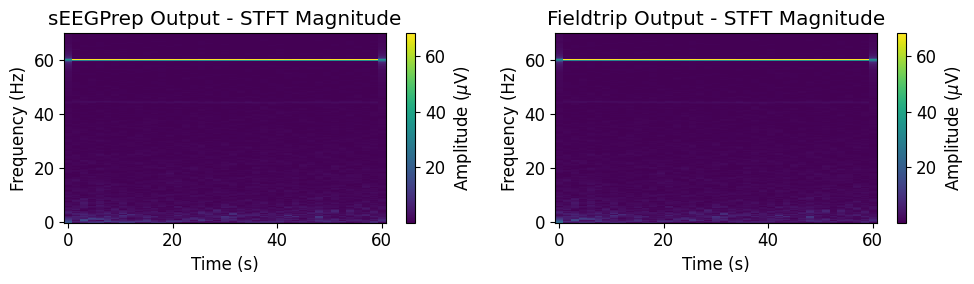

In [158]:
plot_stft_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200, nperseg=3*200, freq_range=[0,70], seconds=60)

## PLI 

In [81]:
# sEEGPrep file
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-PLI_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx_python = edf_epoch.getSignalLabels().index('LPIn2-3')
    labels_python = edf_epoch.getSignalLabels()
    signals_python = []
    for sig in range(len(edf_epoch.getSignalLabels())):
        signals_python.append(edf_epoch.readSignal(sig))
    signals_python = np.vstack(signals_python)
# Fieldtrip file
signals_matlab = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/cleanline.mat')['signals']
labels_matlab = scipy.io.loadmat('/home/mcesped/scratch/code/matlab_code/bipolar_labels_matlab.mat')['labels']
labels = []
for label in labels_matlab:
    labels.append(label[0][0])
labels_matlab = labels

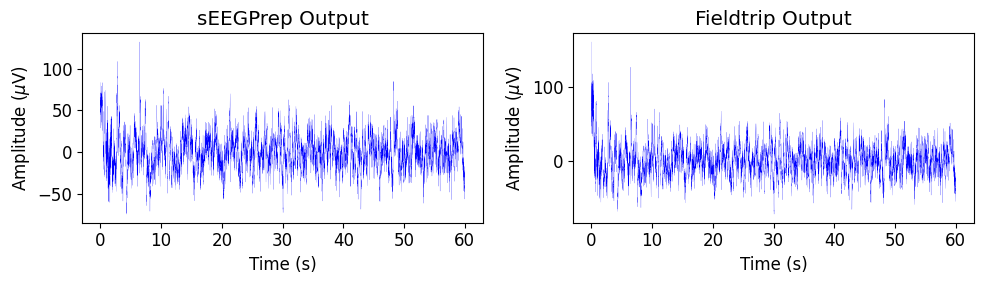

In [82]:
idx_matlab = labels_matlab.index('LPIn2-LPIn3')
plot_time_comparison(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200)

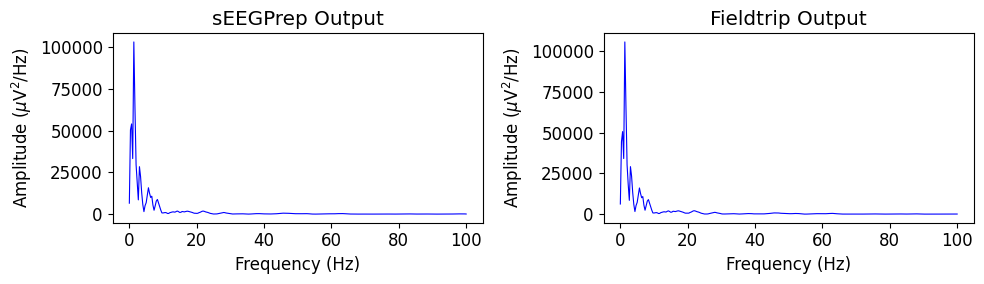

In [83]:
plot_freq_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200)

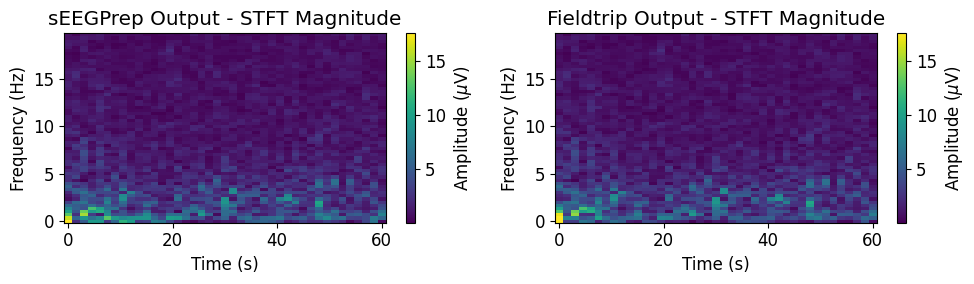

In [84]:
plot_stft_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200, nperseg=3*200)

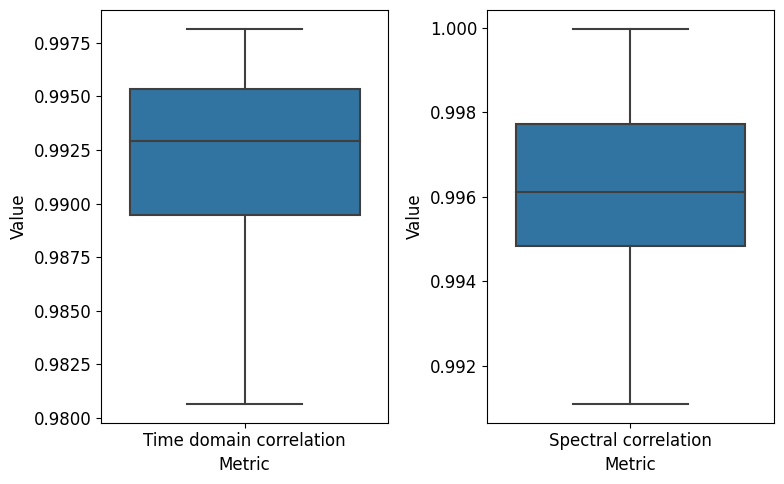

In [85]:
language_comparison(labels_python, labels_matlab, signals_python, signals_matlab, srate=200, map_signals=False)

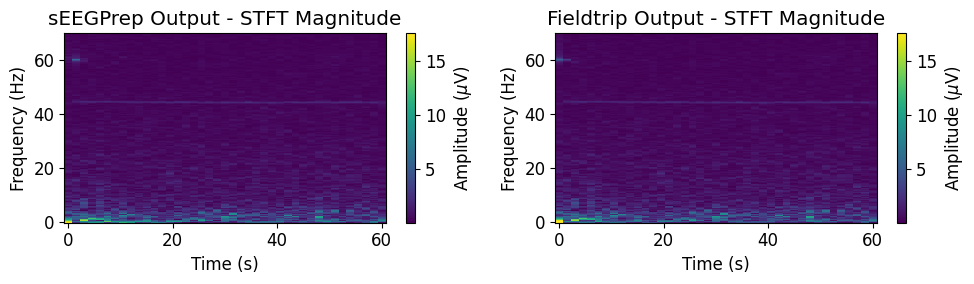

In [169]:
plot_stft_comp(signals_python[idx_python,:], signals_matlab[idx_matlab,:], srate=200, nperseg=3*200, freq_range=[0,70], seconds=60)

### Comparison for different methods

In [3]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import permutation_test
from itertools import combinations
from statsmodels.stats.multitest import fdrcorrection
from statannotations.Annotator import Annotator

In [4]:
mat_contents = sio.loadmat('PLI_results_Python.mat')
zapline_python = mat_contents['y1']
cleanline_python = mat_contents['y2']
removePLI_python = mat_contents['y3']
zapline_python.shape, cleanline_python.shape, removePLI_python.shape

((48000, 100), (48000, 100), (48000, 100))

In [5]:
mat_contents = sio.loadmat('PLI_results_matlab.mat')
zapline_matlab = mat_contents['y1']
cleanline_matlab = mat_contents['y2']
removePLI_matlab = mat_contents['y3']
# New cleanline
mat_contents = sio.loadmat('PLI_results_matlab_cleanline_new.mat')
cleanline_matlab = mat_contents['y2']
zapline_matlab.shape, cleanline_matlab.shape, removePLI_matlab.shape

((48000, 100), (48000, 100), (48000, 100))

In [8]:
from utils import calculate_snr
idx = 47
calculate_snr(zapline_matlab[:,idx], s[:,idx]), calculate_snr(zapline_python[:,idx], s[:,idx])

(21.97081638403582, 21.908427482359837)

In [7]:
mat_contents = sio.loadmat('PLI_test_signals.mat')
eeg_signal_a = mat_contents['eeg_signal_a']
eeg_signal_b = mat_contents['eeg_signal_b']
eeg_signal = mat_contents['noisy_signal']
s = mat_contents['clean_signal']
eeg_signal_a.shape, eeg_signal_b.shape, eeg_signal.shape, s.shape

((48000, 100), (48000, 100), (48000, 100), (48000, 100))

In [12]:
signal_idx = 47

In [37]:
np.mean((s[:,idx]-zapline_matlab[:,idx])**2)

322.7640806468612

In [38]:
np.mean((s[:,idx]-zapline_python[:,idx])**2)

144.34819450259803

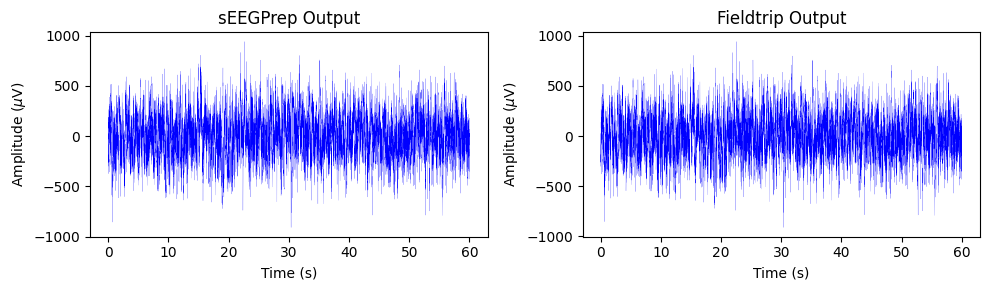

In [13]:
plot_time_comparison(zapline_python[:,signal_idx], zapline_matlab[:,signal_idx], srate=400)

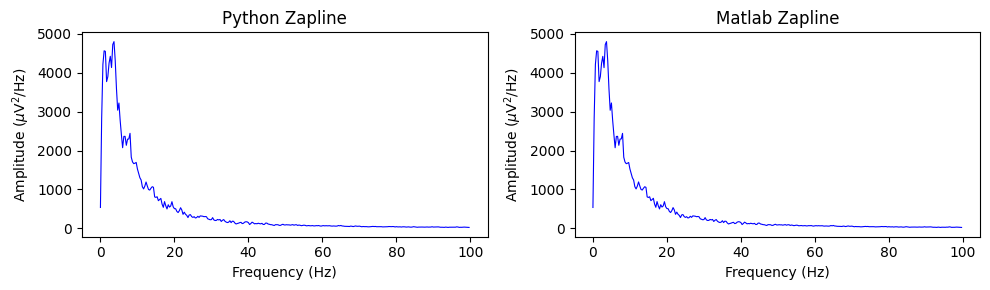

In [14]:
plot_freq_comp(zapline_python[:,signal_idx], zapline_matlab[:,signal_idx], srate=400,titles=['Python Zapline', 'Matlab Zapline'])

In [15]:
from utils import compute_metrics

In [16]:
dict_total = []
for y_python, y_matlab, method in [(zapline_python, zapline_matlab, 'Zapline'),
                                   (cleanline_python, cleanline_matlab, 'Cleanline'),
                                   (removePLI_python, removePLI_matlab, 'removePLI')
                                   ]:
    print(y_python.shape)
    for y, language in zip([y_python, y_matlab], ['Python', 'Matlab']):
        for ind in range(y.shape[-1]):
            metrics = compute_metrics(s[:,ind], y[:,ind], eeg_signal_a[:,ind], srate=400)
            for metric in metrics:
                metric_dict =  dict()
                metric_dict['Metric']=metric
                metric_dict['Value']=metrics[metric]
                metric_dict['chn']=ind
                metric_dict['Method']=method
                metric_dict['Language'] = language
                dict_total.append(metric_dict)

(48000, 100)
(48000, 100)
(48000, 100)


In [17]:
df = pd.DataFrame(dict_total)
df.tail()

,Metric,Value,chn,Method,Language
2995,SNR (dB),25.424518,99,removePLI,Matlab
2996,RMSE - Time Domain ($\mu$V),12.358383,99,removePLI,Matlab
2997,Correlation coefficient,0.999013,99,removePLI,Matlab
2998,Spectral error ($\mu$V$^2$/Hz),18.551834,99,removePLI,Matlab
2999,Attenuation (dB),-12.989821,99,removePLI,Matlab


In [20]:
df_tmp = df[(df.Language=="Python").astype(bool)*(df.Method=='Zapline').astype(bool)*(df.Metric=='SNR (dB)').astype(bool)]
df_tmp.iloc[np.argmin(df_tmp.Value)]

Metric       SNR (dB)
Value       25.467974
chn                15
Method        Zapline
Language       Python
Name: 75, dtype: object

In [23]:
df[(df.chn==47).astype(bool)*(df.Method=='Zapline').astype(bool)*(df.Metric=='SNR (dB)').astype(bool)]


,Metric,Value,chn,Method,Language
235,SNR (dB),25.484071,47,Zapline,Python
735,SNR (dB),21.989333,47,Zapline,Matlab


In [21]:
df_tmp = df[(df.Language=="Matlab").astype(bool)*(df.Method=='Zapline').astype(bool)*(df.Metric=='SNR (dB)').astype(bool)]
df_tmp.iloc[np.argmin(df_tmp.Value)]

Metric       SNR (dB)
Value       21.989333
chn                47
Method        Zapline
Language       Matlab
Name: 735, dtype: object

In [10]:
df.Metric.unique()

array(['SNR (dB)', 'RMSE - Time Domain ($\\mu$V)',
       'Correlation coefficient', 'Spectral error ($\\mu$V$^2$/Hz)',
       'Attenuation (dB)'], dtype=object)

Zapline
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Spectral error ($\mu$V$^2$/Hz)_Python vs. Spectral error ($\mu$V$^2$/Hz)_Matlab: Custom statistical test, P_val:4.270e-01
RMSE - Time Domain ($\mu$V)_Python vs. RMSE - Time Domain ($\mu$V)_Matlab: Custom statistical test, P_val:4.837e-01


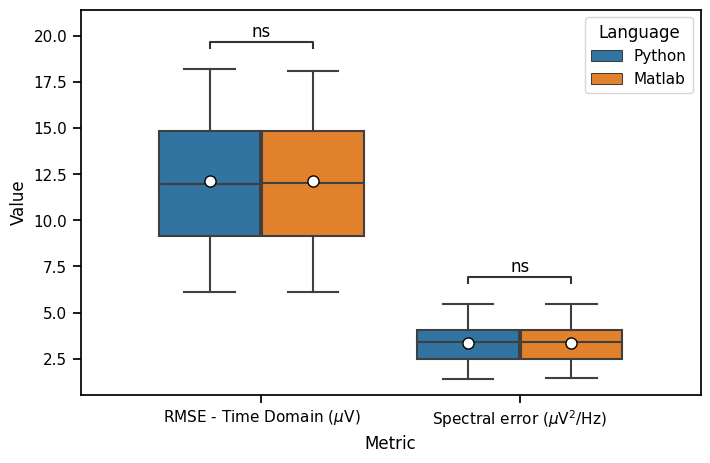

Cleanline
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Spectral error ($\mu$V$^2$/Hz)_Python vs. Spectral error ($\mu$V$^2$/Hz)_Matlab: Custom statistical test, P_val:4.947e-01
RMSE - Time Domain ($\mu$V)_Python vs. RMSE - Time Domain ($\mu$V)_Matlab: Custom statistical test, P_val:4.204e-01


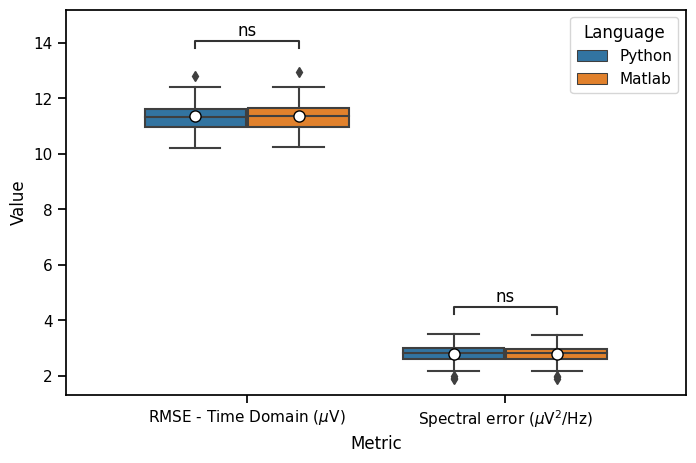

removePLI
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Spectral error ($\mu$V$^2$/Hz)_Python vs. Spectral error ($\mu$V$^2$/Hz)_Matlab: Custom statistical test, P_val:4.529e-01
RMSE - Time Domain ($\mu$V)_Python vs. RMSE - Time Domain ($\mu$V)_Matlab: Custom statistical test, P_val:3.457e-01


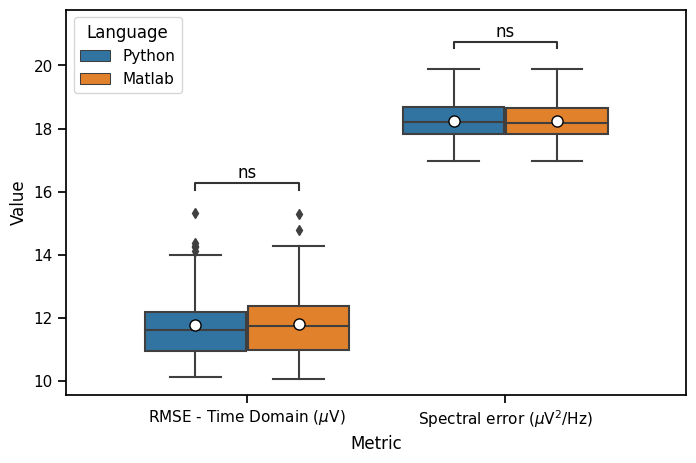

In [18]:
# Generate pairs
elements = df.Language.unique()

# Generate combinations of length 2 without repetition
combinations_without_repetition = list(combinations(elements, 2))

# Run permutation with median
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
    # return np.median(x, axis=axis) - np.median(y, axis=axis)

df_metrics = df.loc[(df.Metric=='RMSE - Time Domain ($\\mu$V)').astype(bool)+
                    (df.Metric=='Spectral error ($\\mu$V$^2$/Hz)').astype(bool)]
for method in df.Method.unique():
    print(method)
    df_tmp = df_metrics.loc[df_metrics.Method==method]

    pairs=[]
    p_vals = []
    for metric in df_tmp.Metric.unique():
        p_vals_tmp = []
        for element_1, element_2 in combinations_without_repetition:
            # print(f'\n Comparison between {net_1} and {net_2}\n')
            x = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Language == element_1).astype(bool),'Value'].values
            y = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Language == element_2).astype(bool),'Value'].values 
            base = statistic(x, y, 0) # Small network has worst performance
            # Permutation testing
            res = permutation_test((x, y), statistic, vectorized=True,
                               n_resamples=100000, alternative='less' if base<0 else 'greater')
            # print('Real diff',res.statistic)
            # print('p-val: ', res.pvalue)
            p_vals_tmp.append(res.pvalue)
            pairs.append([(metric, element_1), (metric, element_2)])
        # Correct them
        significance, corr_p_vals = fdrcorrection(p_vals_tmp)
        p_vals += corr_p_vals.tolist()

    # Plot params
    plotting_parameters = {
        'data': df_tmp,
        'y': "Value",
        'x': "Metric",
        'hue':'Language'
    }
    # sns.boxplot(data=df_tmp, x="Value", y="Metric", hue='Name_Net')
    with sns.plotting_context('notebook', font_scale = 1):
        # Create new plot
        ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
        # Plot with seaborn
        ax = sns.boxplot(**plotting_parameters, showmeans=True,
                meanprops={'marker':'o',
                           'markerfacecolor':'white', 
                           'markeredgecolor':'black',
                           'markersize':'8'})

        # Add annotations
        annotator = Annotator(ax, pairs, **plotting_parameters)
        annotator.configure(text_format="star")
        annotator.set_pvalues_and_annotate(p_vals)
        # Label and show
        plt.show()

Zapline
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Attenuation (dB)_Python vs. Attenuation (dB)_Matlab: Custom statistical test, P_val:4.968e-01
SNR (dB)_Python vs. SNR (dB)_Matlab: Custom statistical test, P_val:4.792e-01


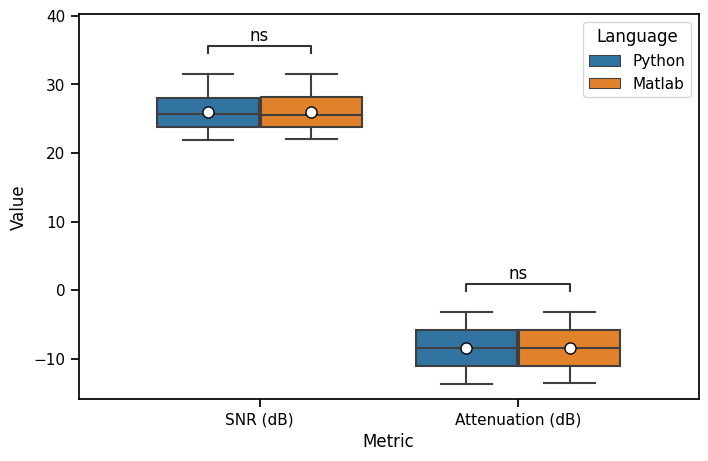

Cleanline
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Attenuation (dB)_Python vs. Attenuation (dB)_Matlab: Custom statistical test, P_val:4.963e-01
SNR (dB)_Python vs. SNR (dB)_Matlab: Custom statistical test, P_val:4.243e-01


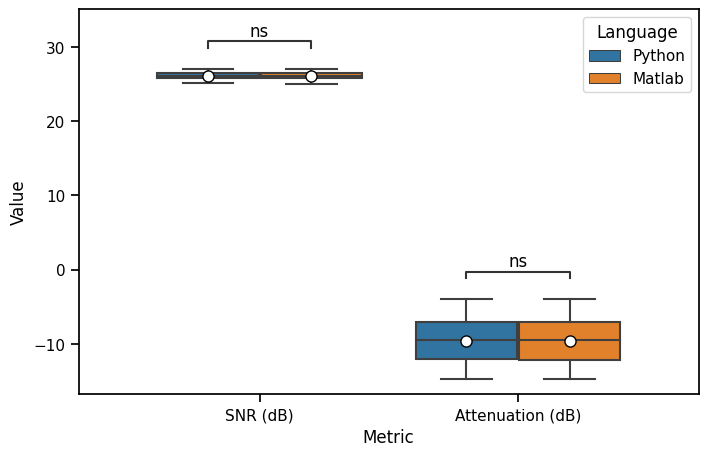

removePLI
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Attenuation (dB)_Python vs. Attenuation (dB)_Matlab: Custom statistical test, P_val:4.520e-01
SNR (dB)_Python vs. SNR (dB)_Matlab: Custom statistical test, P_val:3.378e-01


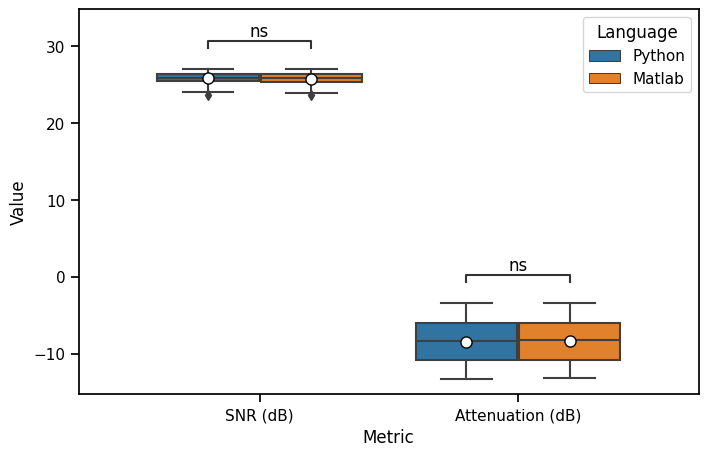

In [19]:
# Generate pairs
elements = df.Language.unique()

# Generate combinations of length 2 without repetition
combinations_without_repetition = list(combinations(elements, 2))

# Run permutation with median
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
    # return np.median(x, axis=axis) - np.median(y, axis=axis)

df_metrics = df.loc[(df.Metric=='SNR (dB)').astype(bool)+
                    (df.Metric=='Attenuation (dB)').astype(bool)]
for method in df.Method.unique():
    print(method)
    df_tmp = df_metrics.loc[df_metrics.Method==method]

    pairs=[]
    p_vals = []
    for metric in df_tmp.Metric.unique():
        p_vals_tmp = []
        for element_1, element_2 in combinations_without_repetition:
            # print(f'\n Comparison between {net_1} and {net_2}\n')
            x = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Language == element_1).astype(bool),'Value'].values
            y = df_tmp.loc[(df.Metric == metric).astype(bool) & (df.Language == element_2).astype(bool),'Value'].values 
            base = statistic(x, y, 0) # Small network has worst performance
            # Permutation testing
            res = permutation_test((x, y), statistic, vectorized=True,
                               n_resamples=100000, alternative='less' if base<0 else 'greater')
            # print('Real diff',res.statistic)
            # print('p-val: ', res.pvalue)
            p_vals_tmp.append(res.pvalue)
            pairs.append([(metric, element_1), (metric, element_2)])
        # Correct them
        significance, corr_p_vals = fdrcorrection(p_vals_tmp)
        p_vals += corr_p_vals.tolist()

    # Plot params
    plotting_parameters = {
        'data': df_tmp,
        'y': "Value",
        'x': "Metric",
        'hue':'Language'
    }
    # sns.boxplot(data=df_tmp, x="Value", y="Metric", hue='Name_Net')
    with sns.plotting_context('notebook', font_scale = 1):
        # Create new plot
        ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
        # Plot with seaborn
        ax = sns.boxplot(**plotting_parameters, showmeans=True,
                meanprops={'marker':'o',
                           'markerfacecolor':'white', 
                           'markeredgecolor':'black',
                           'markersize':'8'})

        # Add annotations
        annotator = Annotator(ax, pairs, **plotting_parameters)
        annotator.configure(text_format="star")
        annotator.set_pvalues_and_annotate(p_vals)
        # Label and show
        plt.show()